<a href="https://colab.research.google.com/github/Alexis-CAPON/cse437-reinforcement-learning/blob/main/lab10_half_cheetah_dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# HalfCheetah: Learn a Dynamics Model from Random Rollouts (Then Validate It)

**Goal:** In this notebook you'll (1) collect random experience tuples \((s_t, a_t, r_t, s_{t+1})\) from `HalfCheetah-v4`, (2) train a neural network to predict **state deltas** \(\Delta s = s_{t+1}-s_t\), and (3) **validate** the model with one-step and multi-step (open-loop) rollouts.

This mirrors the first phase of model-based control (e.g., MPPI): learn a model offline, then use it for planning.



## 0. Requirements

- Python 3.9+
- PyTorch `>= 1.10`
- Gymnasium `>= 0.29`
- MuJoCo with `HalfCheetah-v4` (install `mujoco` and `gymnasium[mujoco]`)

```bash
pip install "gymnasium[mujoco]" mujoco torch matplotlib
```

**Try and understand what RunningNormalizer does.**


In [ ]:
pip install "gymnasium[mujoco]" mujoco torch matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 8.8 MB/s eta 0:00:00


In [ ]:

import os, math, random, time
from dataclasses import dataclass
from typing import Tuple
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym

def to_t(x):
    return th.as_tensor(x, dtype=th.float32)

def fanin_init(m):
    if isinstance(m, nn.Linear):
        bound = 1.0 / math.sqrt(m.weight.size(1))
        nn.init.uniform_(m.weight, -bound, +bound)
        nn.init.zeros_(m.bias)

class RunningNormalizer:
    """Feature-wise running mean/std (Welford)."""
    def __init__(self, dim, eps=1e-8):
        self.dim = dim
        self.count = 0
        self.mean = np.zeros(dim, dtype=np.float64)
        self.M2   = np.zeros(dim, dtype=np.float64)
        self.eps  = eps

    def update(self, x: np.ndarray):
        x = np.asarray(x)
        if x.ndim == 1: x = x[None, :]
        for v in x:
            self.count += 1
            d = v - self.mean
            self.mean += d / self.count
            d2 = v - self.mean
            self.M2 += d * d2

    @property
    def var(self):
        if self.count < 2: return np.ones(self.dim, dtype=np.float64)
        return self.M2 / (self.count - 1 + 1e-12)

    @property
    def std(self):
        return np.sqrt(self.var + self.eps)

    def normalize(self, x): return (x - self.mean) / self.std
    def denormalize(self, x): return x * self.std + self.mean

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); th.manual_seed(seed)



## Initializing Environment and Figure Out Observation Structure

`HalfCheetah-v4` exposes observations as `[qpos[1:], qvel[:]]`. The forward velocity is `qvel[0]`, which sits at index `len(qpos[1:])` inside the observation vector. We'll extract that index for later validation/plots. :::: This is important for planning, if we want to know what each state represents


In [ ]:

set_seed(42)
env = gym.make("HalfCheetah-v4")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
act_low = env.action_space.low
act_high = env.action_space.high

# Find start index of qvel inside obs = [qpos[1:], qvel[:]]
nq = env.unwrapped.model.nq
qvel_start = int(nq - 1)
print("obs_dim:", obs_dim, "act_dim:", act_dim, "qvel_start:", qvel_start)


/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


obs_dim: 17 act_dim: 6 qvel_start: 8


## 🧩 Task 1: Prepare the Replay Buffer
**Goal:** Store transitions \((s_t, a_t, s_{t+1})\) and return training pairs \((x, y) = (s_t, a_t, s_{t+1} - s_t)\).

**Instructions:**
- Implement `add()` to record transitions.
- Add a `sample()` method to randomly sample batch of certain size.



In [ ]:
# Create the class and create a class object
class Replay:
    def __init__(self, obs_dim, act_dim, capacity=300000):
        self.obs = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.act = np.zeros((capacity, act_dim), dtype=np.float32)
        self.nxt = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.rew = np.zeros((capacity, 1), dtype=np.float32)
        self.term = np.zeros((capacity, 1), dtype=np.float32)
        self.ptr = 0; self.size = 0; self.cap = capacity

    def add(self, s, a, r, sp, term):
        self.obs[self.ptr] = s
        self.act[self.ptr] = a
        self.rew[self.ptr] = r
        self.nxt[self.ptr] = sp
        self.term[self.ptr] = term
        self.ptr = (self.ptr + 1) % self.cap
        self.size = min(self.size + 1, self.cap)


    def sample(self, batch):
        idx = np.random.randint(self.size, size=batch)
        return self.obs[idx], self.act[idx], self.nxt[idx], self.rew[idx], self.term[idx]

replay = Replay(obs_dim, act_dim)


## Task 2. Collect Random Rollouts

- Gather random actions for a number of steps to create our training dataset. Collect data for 100000 steps.
- Call the function and fill the replay buffer


In [ ]:
def collect_random(env, replay, steps=10000, seed=42):
    set_seed(seed)
    s, _ = env.reset() # Reset once at the start
    for _ in range(steps):
        a = env.action_space.sample()
        sp, r, term, _, _ = env.step(a)
        replay.add(s, a, r, sp, term)
        s = sp
        if term:
            s, _ = env.reset() # Reset if episode terminates

collect_random(env, replay, steps=10000, seed=42)


## Task 3. Update normalizers from the collected random data in the replay buffer

We normalize inputs (`[s,a]`) and targets (`Δs = s' - s`) for stable training.


In [ ]:
obs_norm = RunningNormalizer(obs_dim)
inp_norm = RunningNormalizer(obs_dim + act_dim)
targ_norm = RunningNormalizer(obs_dim)

# write the function to update the normalizers from the data collected in the buffer
def update_normalizers_from_buffer(replay):
    for i in range(replay.size):
        s, a, _, sp, _ = replay.obs[i], replay.act[i], replay.rew[i], replay.nxt[i], replay.term[i]
        obs_norm.update(s)
        inp_norm.update(np.concatenate([s, a]))
        targ_norm.update(sp - s)


update_normalizers_from_buffer(replay)
print("Normalizers ready.")

Normalizers ready.



## Defining the Neural Dynamics Model

We predict **normalized** `Δs` from **normalized** `[s, a]`.
NN parameters:

- initialize a deterministic NN with a ExponentialLR sceduler( that decays the learning rate with epoch)
- width = 200, depth = 3, lr = 1e-3, weight_decay - 1e-5, gamma for scheduler = 0.8
- These are a starting point but not the best parameters.


In [ ]:

class DetMLP(nn.Module):
    """Predicts Δstate deterministically."""
    def __init__(self, in_dim, out_dim, width=200, depth=3):
        super().__init__()
        layers = []
        last = in_dim
        for _ in range(depth):
            layers += [nn.Linear(last, width), nn.ReLU()]
            last = width
        layers += [nn.Linear(last, out_dim)]
        self.net = nn.Sequential(*layers)
        self.apply(fanin_init)

    def forward(self, x):
        return self.net(x)

in_dim = obs_dim + act_dim
out_dim = obs_dim
model = DetMLP(in_dim, out_dim, width=200, depth=3)
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.8)



## Task 4. Train the Model

We minimize MSE between predicted normalized `Δs` and target normalized `Δs`.

- Train in batches, keep the batch size 256
- Use a learning rate scheduler that decays the learning rate as training progresses. You may use the pytorch utility. See how the learning rate decays with each epoch.
- Train for 30 epochs and plot the training curve. Loss vs epoch.
- Find the best parameters(defined in the previous block)



Epoch 1/30, Loss: 0.5481, LR: 0.000800
Epoch 2/30, Loss: 0.1812, LR: 0.000640
Epoch 3/30, Loss: 0.1363, LR: 0.000512
Epoch 4/30, Loss: 0.1167, LR: 0.000410
Epoch 5/30, Loss: 0.1088, LR: 0.000328
Epoch 6/30, Loss: 0.1019, LR: 0.000262
Epoch 7/30, Loss: 0.0987, LR: 0.000210
Epoch 8/30, Loss: 0.0958, LR: 0.000168
Epoch 9/30, Loss: 0.0938, LR: 0.000134
Epoch 10/30, Loss: 0.0934, LR: 0.000107
Epoch 11/30, Loss: 0.0918, LR: 0.000086
Epoch 12/30, Loss: 0.0921, LR: 0.000069
Epoch 13/30, Loss: 0.0897, LR: 0.000055
Epoch 14/30, Loss: 0.0920, LR: 0.000044
Epoch 15/30, Loss: 0.0913, LR: 0.000035
Epoch 16/30, Loss: 0.0905, LR: 0.000028
Epoch 17/30, Loss: 0.0872, LR: 0.000023
Epoch 18/30, Loss: 0.0894, LR: 0.000018
Epoch 19/30, Loss: 0.0884, LR: 0.000014
Epoch 20/30, Loss: 0.0884, LR: 0.000012
Epoch 21/30, Loss: 0.0885, LR: 0.000009
Epoch 22/30, Loss: 0.0895, LR: 0.000007
Epoch 23/30, Loss: 0.0896, LR: 0.000006
Epoch 24/30, Loss: 0.0879, LR: 0.000005
Epoch 25/30, Loss: 0.0883, LR: 0.000004
Epoch 26/

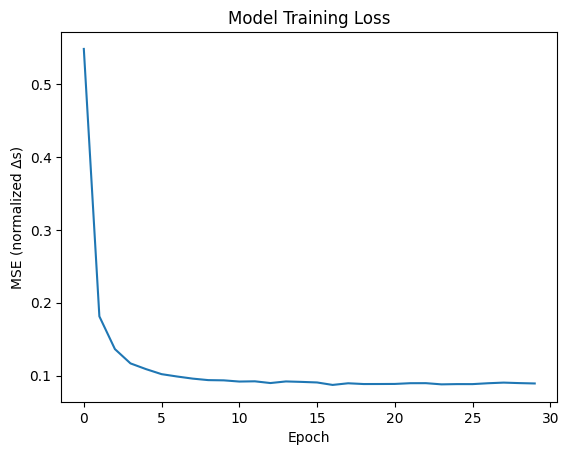

In [ ]:
def train_model(model, replay, epochs=30, batch_size=256):
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        num_batches = replay.size // batch_size
        for _ in range(num_batches):
            s, a, nxt, _, _ = replay.sample(batch_size)

            # Normalize inputs and targets
            inp = np.concatenate([s, a], axis=1)
            norm_inp = inp_norm.normalize(inp)
            delta_s = nxt - s
            norm_delta_s = targ_norm.normalize(delta_s)

            # Convert to tensors
            norm_inp_t = to_t(norm_inp)
            norm_delta_s_t = to_t(norm_delta_s)

            # Zero gradients, forward pass, compute loss, backward pass, step optimizer
            opt.zero_grad()
            pred_norm_delta_s = model(norm_inp_t)
            loss = nn.MSELoss()(pred_norm_delta_s, norm_delta_s_t)
            loss.backward()
            opt.step()

            epoch_loss += loss.item()

        # Decay learning rate
        scheduler.step()

        avg_epoch_loss = epoch_loss / num_batches
        losses.append(avg_epoch_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_epoch_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

    return losses

losses = train_model(model, replay, epochs=30, batch_size=256)
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE (normalized Δs)")
plt.title("Model Training Loss")
plt.show()

## Task 5. Validate your model: One-Step and Multi-Step Prediction Error

- Evaluate your trained model on a held-out set of random transitions.
Generate a batch of unseen samples, predict the next-state delta, and compute the one-step MSE.

- Repeat with open-loop rollouts of length k.
Drive both the real environment and the model with the same action sequence, then report how prediction error grows across steps.

One-step prediction MSE: 0.0892


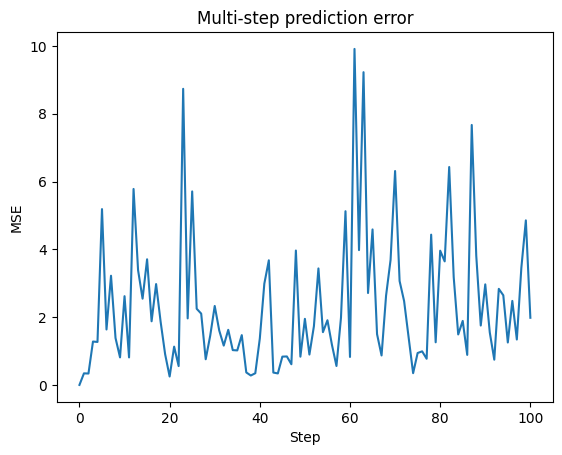

In [ ]:
# One-step prediction error
def evaluate_one_step(model, replay, batch_size=256):
    model.eval()
    with th.no_grad():
        s, a, nxt, _, _ = replay.sample(batch_size)
        inp = np.concatenate([s, a], axis=1)
        norm_inp = inp_norm.normalize(inp)
        delta_s = nxt - s
        norm_delta_s = targ_norm.normalize(delta_s)

        norm_inp_t = to_t(norm_inp)
        norm_delta_s_t = to_t(norm_delta_s)

        pred_norm_delta_s = model(norm_inp_t)
        loss = nn.MSELoss()(pred_norm_delta_s, norm_delta_s_t)
    return loss.item()

one_step_mse = evaluate_one_step(model, replay)
print(f"One-step prediction MSE: {one_step_mse:.4f}")

# Multi-step prediction error
def evaluate_multi_step(env, model, k=100, seed=2024):
    model.eval()
    set_seed(seed)
    s, _ = env.reset()
    real_states = [s.copy()]
    model_states = [s.copy()]
    actions = [env.action_space.sample() for _ in range(k)]

    for a in actions:
        # Real environment step
        sp, r, term, _, _ = env.step(a)
        real_states.append(sp.copy())

        # Model prediction step
        inp = np.concatenate([model_states[-1], a])
        norm_inp = inp_norm.normalize(inp)
        norm_inp_t = to_t(norm_inp).unsqueeze(0)
        with th.no_grad():
            pred_norm_delta_s = model(norm_inp_t)
        pred_delta_s = targ_norm.denormalize(pred_norm_delta_s.squeeze(0).numpy())
        model_states.append(model_states[-1] + pred_delta_s)

        if term: break

    real_states = np.array(real_states)
    model_states = np.array(model_states)

    # Compute MSE at each step
    mse_per_step = np.mean((real_states - model_states)**2, axis=1)
    return mse_per_step

mse_per_step = evaluate_multi_step(env, model, k=100)

plt.figure()
plt.plot(mse_per_step)
plt.xlabel("Step")
plt.ylabel("MSE")
plt.title("Multi-step prediction error")
plt.show()


## Task 6. Visualize Rollout Trajectories

**Setup**
Call model.eval() so gradients stay off.
Reset the env with the provided seed; keep a copy of the initial observation.


**Choose actions**
Pre-sample k actions from env.action_space.sample() so the real system and the model rollout see the same sequence.

**Roll forward**
For each action:
Step the real env (env.step(a)), append the new observation.
For the model path:
Build [s_model, a], normalize via inp_norm.normalize, turn into a tensor with to_t.
Run the network, de-normalize with targ_norm.denormalize, add to the last model state, append.
Stop early if the env terminates or truncates.

**Plot**
Plot the real trajectory as one line, model trajectory as another.



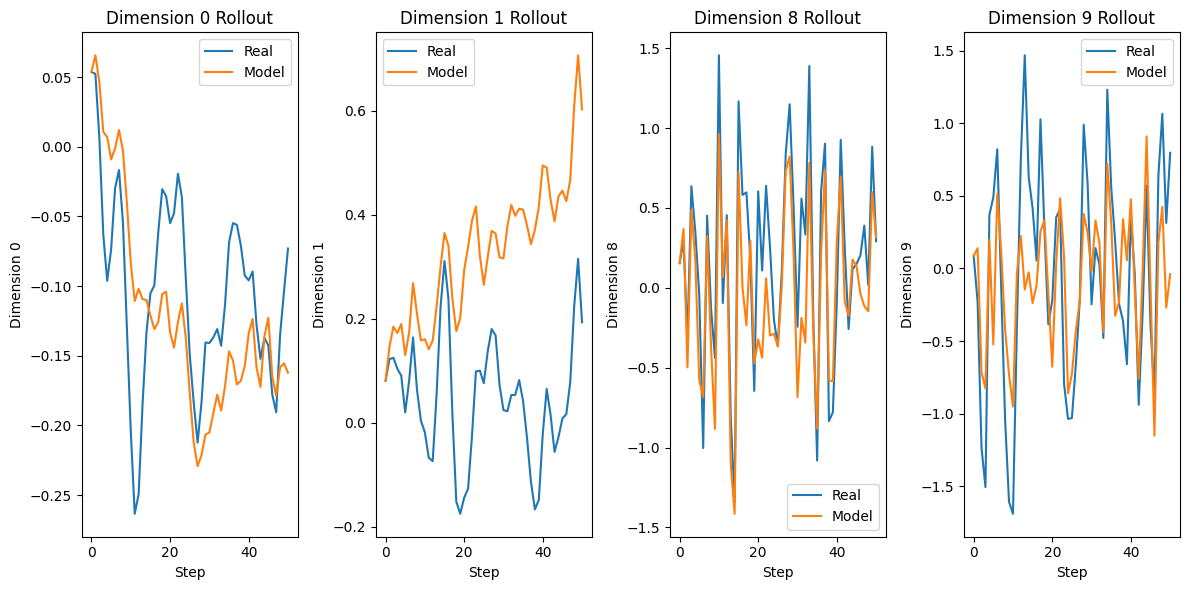

In [ ]:
def visualize_rollout(env, model, k=50, dims=(0, 5, 10), seed=2025):
    model.eval()
    set_seed(seed)
    s, _ = env.reset()
    real_states = [s.copy()]
    model_states = [s.copy()]
    actions = [env.action_space.sample() for _ in range(k)]

    for a in actions:
        # Real environment step
        sp, r, term, _, _ = env.step(a)
        real_states.append(sp.copy())

        # Model prediction step
        inp = np.concatenate([model_states[-1], a])
        norm_inp = inp_norm.normalize(inp)
        norm_inp_t = to_t(norm_inp).unsqueeze(0)
        with th.no_grad():
            pred_norm_delta_s = model(norm_inp_t)
        pred_delta_s = targ_norm.denormalize(pred_norm_delta_s.squeeze(0).numpy())
        model_states.append(model_states[-1] + pred_delta_s)

        if term: break

    real_states = np.array(real_states)
    model_states = np.array(model_states)

    plt.figure(figsize=(12, 6))
    for i, dim in enumerate(dims):
        plt.subplot(1, len(dims), i + 1)
        plt.plot(real_states[:, dim], label="Real")
        plt.plot(model_states[:, dim], label="Model")
        plt.xlabel("Step")
        plt.ylabel(f"Dimension {dim}")
        plt.title(f"Dimension {dim} Rollout")
        plt.legend()
    plt.tight_layout()
    plt.show()

# Uncomment to visualize
dims = [0, 1, qvel_start, qvel_start + 1]
visualize_rollout(env, model, k=50, dims=dims)#(qvel_start, qvel_start+1, qvel_start+2))


## 9. Answer the questions :

1. How good is your model?
2. Is this training enough for planning, or do we need continual training?
3. How is this system different from the mountain car problem? Why can't we learn this in one episode?
4. Why do we use a runningnormalizer instead of a static normalizer? Think about the nature of the algorithm taught in class.



**How good is your model?**
The model is quite good on higher dimension rollout.

**Is this training enough for planning, or do we need continual training?** We could try continual training but the model is able to sence the tendance.

**How is this system different from the mountain car problem? Why can't we learn this in one episode?**
There are more actions and more state, is not as simple as the mountain car problem in 2 dimension. It's too much to be able to learn in one episode.

**Why do we use a runningnormalizer instead of a static normalizer? Think about the nature of the algorithm taught in class.**
The running normalizer allow to normalize with the data processed by batch and we can't normalize all the data in once in our problem.